In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR
from datasets import inputs

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
dataset = inputs.Sim1DFeederAndCache(
    steps_in_phases=[0,2000,0],
    left_right_stay_prob=[4,1,1]
    )

# Sanity Check Plots

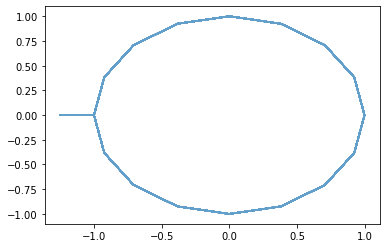

In [3]:
plt.figure();
plt.plot(dataset.xs, dataset.ys, alpha=0.7)
plt.show()

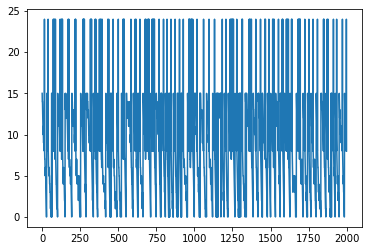

In [4]:
plt.figure();
plt.plot(dataset.state_inputs[:2000])
plt.show()

# Run through model

In [5]:
def get_M(T, gamma):
    return np.linalg.pinv(np.eye(T.shape[0]) - gamma*T)
    
def normalize(T):
    row_sums = np.sum(T, axis=1)
    unvisited_states = (row_sums == 0)
    T = T/row_sums[:, np.newaxis]
    T[unvisited_states] = 0
    return T

In [6]:
outputs = []
gamma = 0.9
T_counts = np.zeros((dataset.num_states, dataset.num_states))
prev_state = None
for step in np.arange(dataset.num_steps):
    curr_state = dataset.state_inputs[step]
    _M = get_M(normalize(T_counts), gamma)
    outputs.append(_M[curr_state,:])
    if prev_state is None:
        prev_state = curr_state
        continue
    T_counts[prev_state, curr_state] += 1
    prev_state = curr_state
outputs = np.array(outputs)

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_35696/628107314.py:7: RuntimeWarning: invalid value encountered in true_divide
  T = T/row_sums[:, np.newaxis]


# Lineplots: spatial states + feeder cell

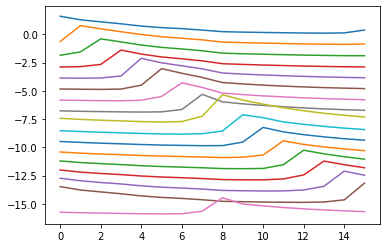

In [7]:
all_ffs = []
mod_state_inputs = np.mod(dataset.state_inputs, dataset.num_spatial_states)
neurs_to_plot = np.concatenate((
    np.arange(dataset.num_spatial_states),
    [dataset.feeder_state + dataset.num_spatial_states],
    #[dataset.cache_state + dataset.num_spatial_states]
    ))
plt.figure()
plt_idx = 0
plt_idx_interval = -1.
for neur in neurs_to_plot:
    activity = outputs[:, neur]
    ff = np.zeros(dataset.num_spatial_states)
    for state in np.arange(dataset.num_spatial_states):
        ff[state] = np.mean(
            activity[mod_state_inputs==state]
            )
    plt.plot(ff + plt_idx)
    plt_idx += plt_idx_interval
    all_ffs.append(ff)
all_ffs = np.array(all_ffs)
plt.show()

# Heatmap (Spatial States only)

In [8]:
all_ffs = []
mod_state_inputs = np.mod(dataset.state_inputs, dataset.num_spatial_states)
neurs_to_plot = np.concatenate((
    np.arange(dataset.num_spatial_states),
    #[dataset.feeder_state + dataset.num_spatial_states],
    #[dataset.cache_state + dataset.num_spatial_states]
    ))
for neur in neurs_to_plot:
    activity = outputs[:, neur]
    ff = np.zeros(dataset.num_spatial_states)
    for state in np.arange(dataset.num_spatial_states):
        ff[state] = np.mean(
            activity[mod_state_inputs==state]
            )
    all_ffs.append(ff)
all_ffs = np.array(all_ffs)

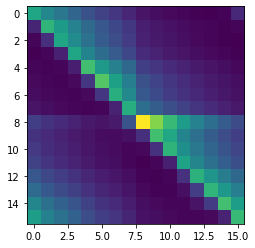

In [9]:
plt.figure()
plt.imshow(all_ffs[np.argsort(np.argmax(all_ffs,axis=1))])
plt.show()

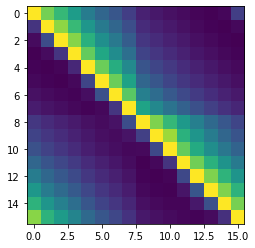

In [10]:
plt.figure()
ffs_to_plot = all_ffs[np.argsort(np.argmax(all_ffs,axis=1))]
plt.imshow(ffs_to_plot/np.max(ffs_to_plot,axis=1)[:,np.newaxis])
plt.show()

# Static M

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_35696/628107314.py:7: RuntimeWarning: invalid value encountered in true_divide
  T = T/row_sums[:, np.newaxis]


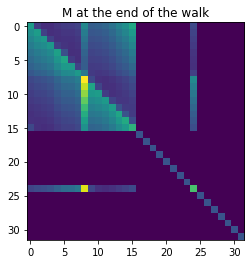

In [21]:
M = get_M(normalize(T_counts), 0.95)
plt.figure()
plt.imshow(M)
plt.title('M at the end of the walk')
plt.show()

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_35696/628107314.py:7: RuntimeWarning: invalid value encountered in true_divide
  T = T/row_sums[:, np.newaxis]


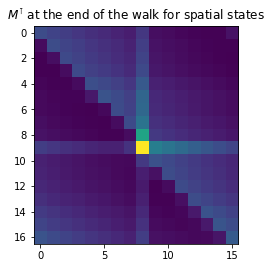

In [41]:
M = get_M(normalize(T_counts), 0.95)
M = M[:, np.concatenate((np.arange(8), [24], np.arange(8,16)))]
aliased_M = M[:16,:17] + M[16:,:17]
plt.figure()
plt.imshow(aliased_M.T)
plt.title('$M^\intercal$ at the end of the walk for spatial states')
plt.show()

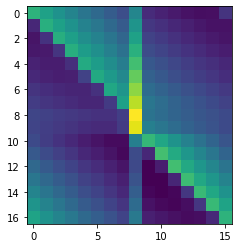

In [42]:
def z_score(M):
    """ Z-Scores by COLUMNS """
    M = M.copy()
    M -= np.mean(M, axis=0)[np.newaxis,:]
    M /= np.std(M, axis=0)[np.newaxis,:]
    return M
    
plt.figure()
norm_aliased_M = z_score(aliased_M)
plt.imshow(norm_aliased_M.T)
plt.show()

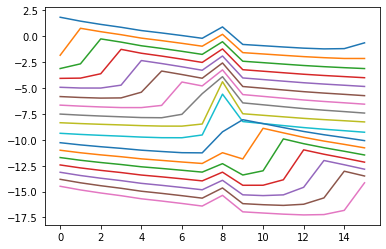

In [43]:
plt_idx = 0
plt_step = -1.
plt.figure()
for ff in norm_aliased_M.T:
    plt.plot(ff + plt_idx)
    plt_idx += plt_step
plt.show()

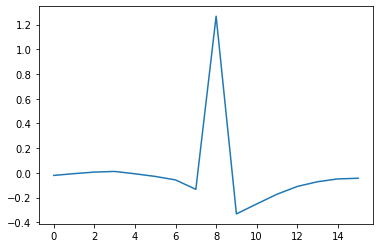

In [36]:
plt.figure()
plt.plot(np.mean(norm_aliased_M.T, axis=0))
plt.show()

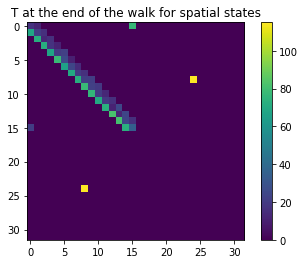

In [15]:
plt.figure()
plt.imshow(T_counts)
plt.title('T at the end of the walk for spatial states')
plt.colorbar()
plt.show()

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_35696/628107314.py:7: RuntimeWarning: invalid value encountered in true_divide
  T = T/row_sums[:, np.newaxis]


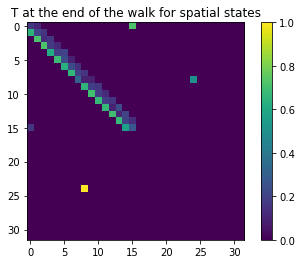

In [16]:
plt.figure()
plt.imshow(normalize(T_counts))
plt.title('T at the end of the walk for spatial states')
plt.colorbar()
plt.show()

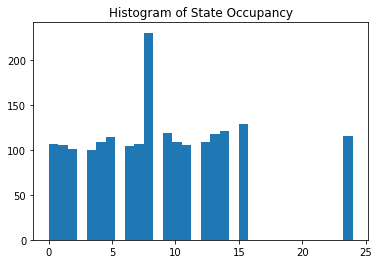

In [17]:
plt.figure()
plt.hist(dataset.state_inputs, bins=32)
plt.title('Histogram of State Occupancy')
plt.show()